# Efficient parameter estimation

This uses a problem from radio interferometry of inferring ionospheric parameters from phase data. We'll explore how to use JAXNS when the focus is on efficient parameter estimation rather than evidence calculation. 


In [1]:


import pylab as plt
import tensorflow_probability.substrates.jax as tfp
from jax import random, numpy as jnp

from jaxns import NestedSampler
from jaxns import bruteforce_evidence

tfpd = tfp.distributions


/home/albert/git/jaxns/src/jaxns/internals/mixed_precision.py:14: UserWarning: JAX x64 is not enabled. Setting it now. Check for errors.
  warnings.warn("JAX x64 is not enabled. Setting it now. Check for errors.")
INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': 
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


In [2]:

TEC_CONV = -8.4479745  #rad*MHz/mTECU
CLOCK_CONV = (2e-3 * jnp.pi)  #rad/MHz/ns


def wrap(phi):
    return (phi + jnp.pi) % (2 * jnp.pi) - jnp.pi


def generate_data(key, uncert):
    """
    Generate gain data where the phase have a clock const and tec component. This is a model of the impact of the ionosphere on the propagation of radio waves, part of radio interferometry:

    phase[:] = tec * (tec_conv / freqs[:]) + clock * (clock_conv * freqs[:]) + const

    then the gains are:

        gains[:] ~ Normal[{cos(phase[:]), sin(phase[:])}, uncert^2 * I]

    phase_obs[:] = ArcTan[gains.imag, gains.real]

    Args:
        key:
        uncert: uncertainty of the gains

    Returns:
        phase_obs, freqs
    """
    freqs = jnp.linspace(121, 166, 24)  #MHz
    tec = 90.  #mTECU
    const = 2.  #rad
    clock = 0.5  #ns
    phase = wrap(tec * (TEC_CONV / freqs) + clock * (CLOCK_CONV * freqs) + const)
    Y = jnp.concatenate([jnp.cos(phase), jnp.sin(phase)], axis=-1)
    Y_obs = Y + uncert * random.normal(key, shape=Y.shape)
    phase_obs = jnp.arctan2(Y_obs[..., freqs.size:], Y_obs[..., :freqs.size])
    return phase, phase_obs, freqs


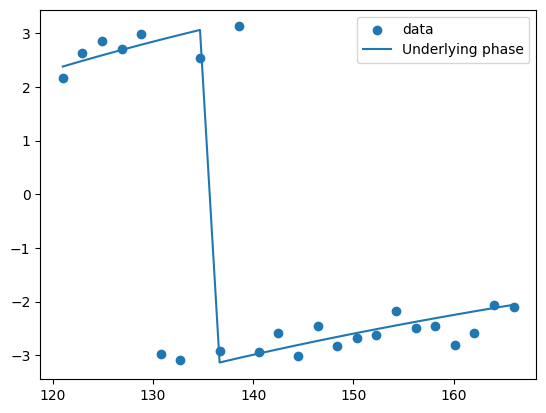

In [3]:
# Generate data
key = random.PRNGKey(43)
key, data_key = random.split(key)
phase_underlying, phase_obs, freqs = generate_data(data_key, 0.25)
plt.scatter(freqs, phase_obs, label='data')
plt.plot(freqs, phase_underlying, label='Underlying phase')
plt.legend()
plt.show()
# Note: the phase wrapping makes this a difficult problem to solve. As we'll see, the posterior is rather complicated.

In [4]:

from jaxns import Prior, Model


def log_normal(x, mean, scale):
    return tfpd.Normal(loc=mean, scale=scale).log_prob(x)


def log_likelihood(dtec, const, clock, uncert):
    phase = dtec * (TEC_CONV / freqs) + const + clock * (CLOCK_CONV * freqs)
    logL = log_normal(wrap(wrap(phase) - wrap(phase_obs)), 0., uncert)
    return jnp.sum(logL)


def prior_model():
    tec = yield Prior(tfpd.Uniform(-300, 300.), name='dtec')
    const = yield Prior(tfpd.Uniform(-jnp.pi, jnp.pi), name='const')
    clock = yield Prior(tfpd.Uniform(-2., 2.), name='clock')
    uncert = yield Prior(tfpd.HalfNormal(0.25), name='uncert')

    return tec, const, clock, uncert


model = Model(prior_model=prior_model, log_likelihood=log_likelihood)

model.sanity_check(random.PRNGKey(0), S=100)

log_Z_true = bruteforce_evidence(model=model, S=80)
print(f"Approx. log(Z)={log_Z_true}")  # Unsure if this grid is sufficient to get a good estimate of the evidence.

INFO:jaxns:Sanity check...
INFO:jaxns:Sanity check passed


Approx. log(Z)=-8.74251800745667


# First the normal nested sampler (parameter_estimation=False)

--------
Termination Conditions:
Small remaining evidence
--------
likelihood evals: 233772
samples: 1800
phantom samples: 0
likelihood evals / sample: 129.9
phantom fraction (%): 0.0%
--------
logZ=-8.81 +- 0.3
max(logL)=0.32
H=-7.48
ESS=188
--------
clock: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
clock: -0.41 +- 0.88 | -1.5 / -0.4 / 0.63 | -1.6 | -1.65
--------
const: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
const: -0.2 +- 1.9 | -2.7 / -0.4 / 2.2 | -1.4 | -1.4
--------
dtec: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
dtec: 90.0 +- 17.0 | 71.0 / 90.0 / 110.0 | 107.0 | 106.0
--------
uncert: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
uncert: 0.266 +- 0.036 | 0.228 / 0.261 / 0.315 | 0.234 | 0.238
--------


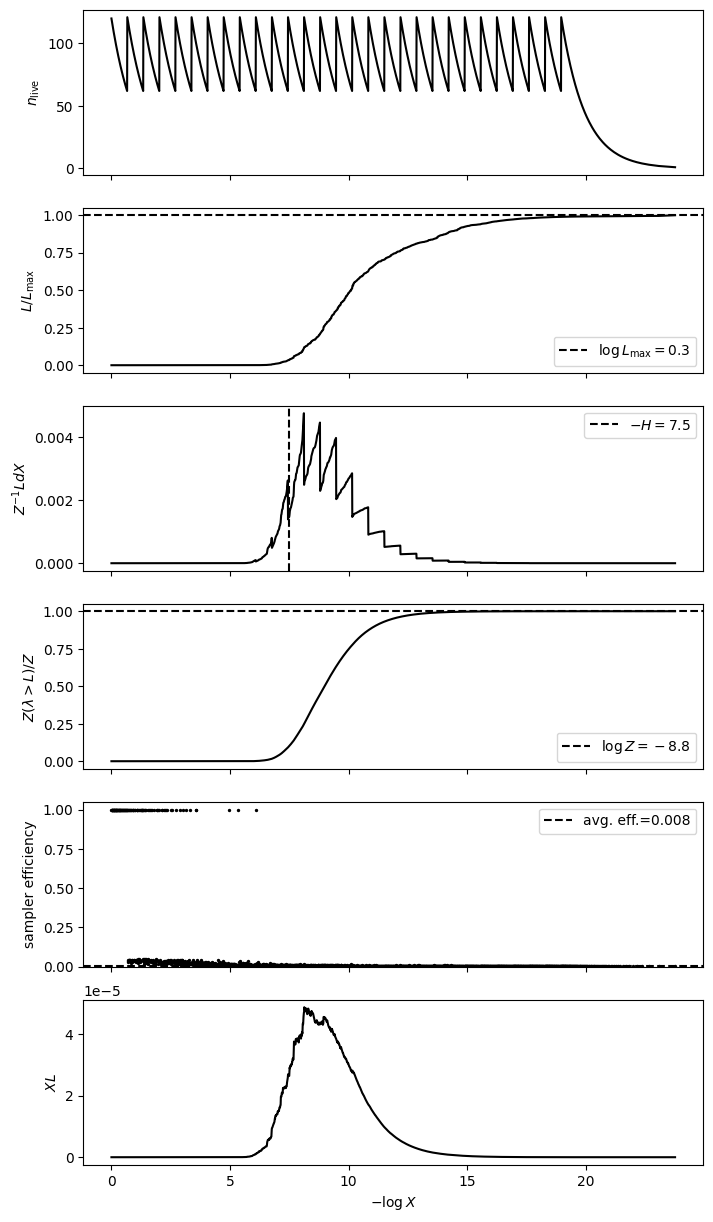

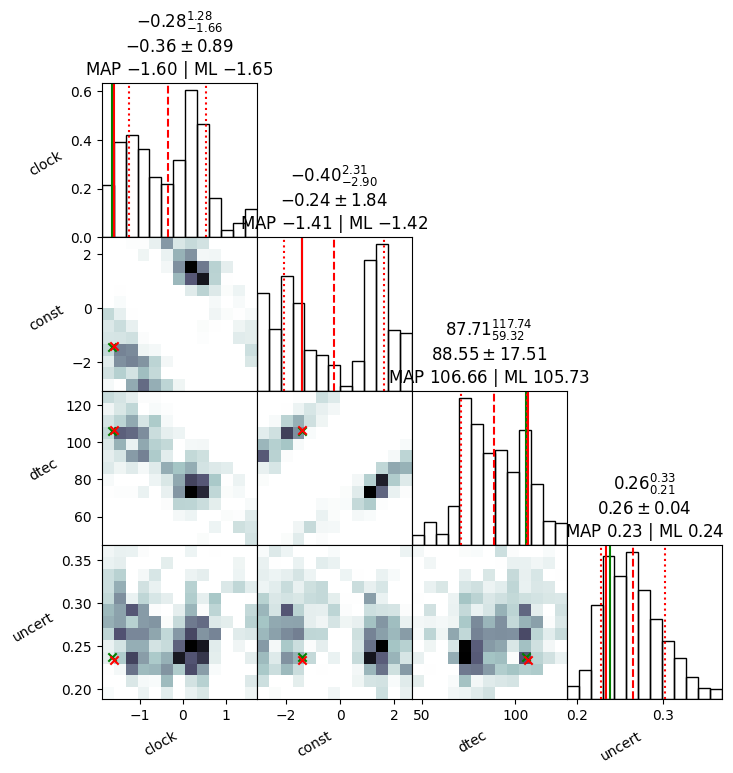

In [5]:
import jax

# Create the nested sampler class. In this case without any tuning.
ns = NestedSampler(model=model, parameter_estimation=False)
termination_reason, state = jax.jit(ns)(random.PRNGKey(432345987))
results = ns.to_results(termination_reason=termination_reason, state=state)
ns.summary(results)
ns.plot_diagnostics(results)
ns.plot_cornerplot(results)

# Now with parameter estimation enabled

Notice fewer likelihood evaluations are needed. 

--------
Termination Conditions:
XL < max(XL) * peak_XL_frac
--------
likelihood evals: 146580
samples: 6420
phantom samples: 5040
likelihood evals / sample: 22.8
phantom fraction (%): 78.5%
--------
logZ=-8.85 +- 0.34
max(logL)=0.31
H=-7.43
ESS=208
--------
clock: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
clock: -0.32 +- 0.91 | -1.48 / -0.25 / 0.68 | -1.6 | -1.56
--------
const: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
const: -0.3 +- 1.9 | -2.7 / -0.6 / 2.1 | -1.4 | -1.5
--------
dtec: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
dtec: 88.0 +- 17.0 | 70.0 / 87.0 / 112.0 | 107.0 | 105.0
--------
uncert: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
uncert: 0.264 +- 0.037 | 0.222 / 0.259 / 0.315 | 0.234 | 0.237
--------


/home/albert/git/jaxns/src/jaxns/plotting.py:45: UserWarning: Found samples with zero likelihood evaluations.
  warnings.warn("Found samples with zero likelihood evaluations.")


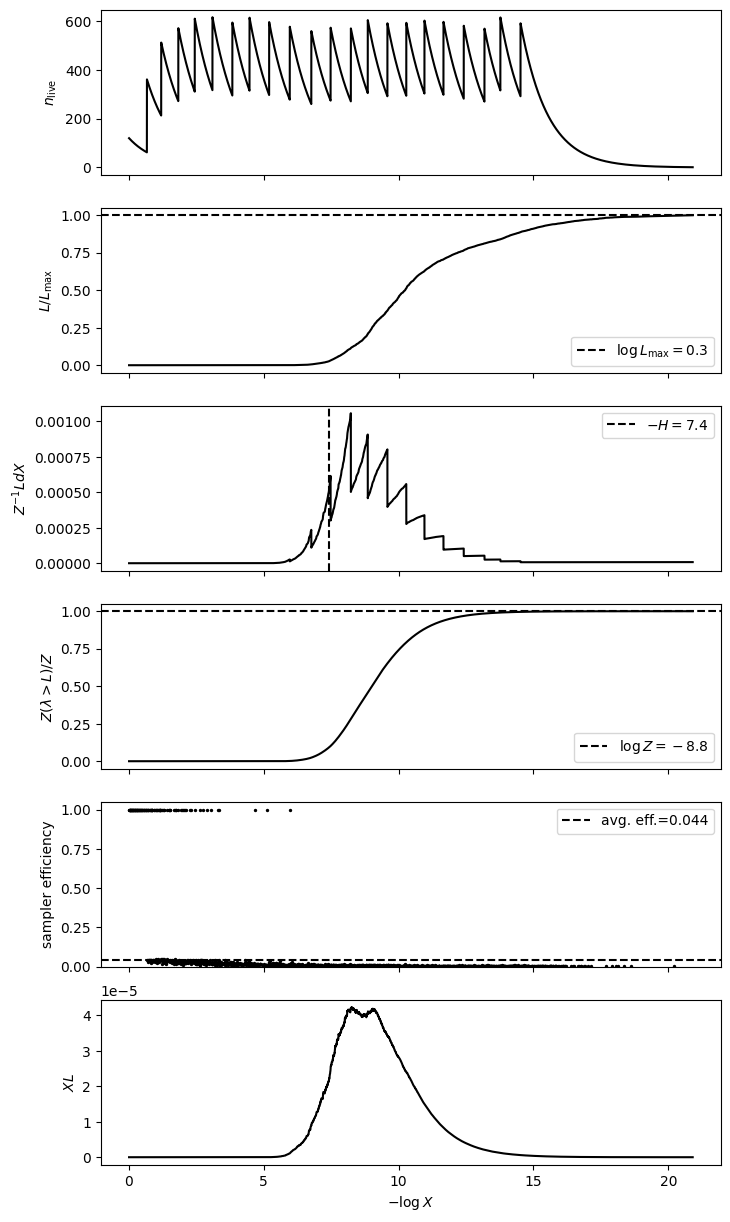

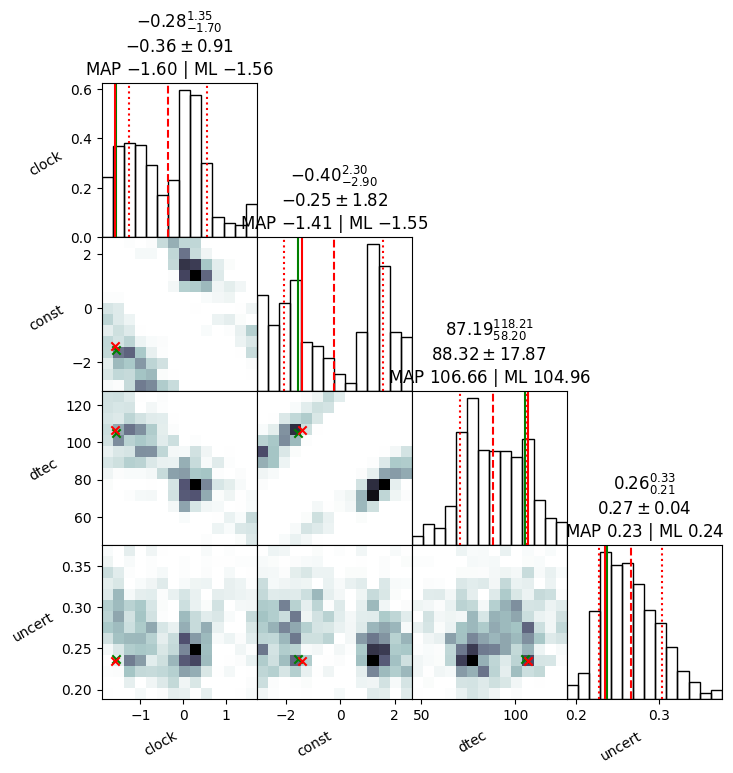

In [6]:
# Create the nested sampler class. In this case without any tuning.
ns = NestedSampler(model=model, parameter_estimation=True)
termination_reason, state = jax.jit(ns)(random.PRNGKey(432345987))
results = ns.to_results(termination_reason=termination_reason, state=state)
ns.summary(results)
ns.plot_diagnostics(results)
ns.plot_cornerplot(results)